## Установка зависимостей 

In [1]:
# !pip install -r requirements2.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

from scipy.ndimage import generic_filter

## Функции для работы

Для простоты работаем с черно-белыми изображениями.

In [3]:
# функция, отображающая изображения до и после применения фильтров
def represent(img_before, img_after):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(img_before, cmap='gray')
    ax2.imshow(img_after, cmap='gray');

In [4]:
# функция, открывающая изображение из файла и возвращающая черно-белый его вариант
def open_image(path: str) -> np.array:
    # избавляемся от возможных проблем с альфа-каналом, проверяя расширение файла
    sfx = Path(path).suffix
    # особенность OpenCV - она открывает изображения в BGR вместо RGB, поэтому для правильного отображения нужно конвертировать цветовую схему
    color_scheme = cv.COLOR_BGRA2GRAY if sfx == '.png' else cv.COLOR_BGR2GRAY
    img = cv.cvtColor(cv.imread(path), color_scheme)
    return img

In [5]:
# функция, проводящая свертку с заданным ядром и функцией и отображающая результат
def convolve_and_show(image: np.array, kernel: np.array, function):
    before = image.copy()
    # пишем окончательную функцию (нотация фильтра scipy требует так). В ней умножаем окно свертки на ядро и берем заданную функцию от произведения
    def funx(chunk, kernel=kernel, function=function):
        return function(chunk * kernel.ravel())
    # применяем фильтр
    after = generic_filter(image/255, funx, footprint=np.ones_like(kernel), mode='constant', cval=0.0)
    represent(before, after)

Заметьте, мы также параметризуем **функцию**, с которой свертка будет совершаться.

В **сверточных фильтрах** использутся **суммирование**, т.е. функция np.sum.

Однако ничто не мешает попробовать взять другие функции - **среднее** np.average, **максимум** np.max , **минимум** np.min и так далее, куда фантазии хватит. Более того, внутри функции funx вместо поэлементного умножения можно брать другие операции: вычитание, сложение и т.п. Смотрите ниже функцию для эффекта боке.

Можно даже написать ее самому - помните, что она должна принимать на вход двумерный массив numpy.array, а на выходе возвращать число - или np.uint8, или float от 0 до 1.

Ниже сделаем специальную функцию для проявления эффекта боке, с параметром в виде размера эллипса, обеспечивающего этот эффект.

### Эффект боке 

In [6]:
def bokeh_effect(img: np.array, size: tuple):
    kernel = np.invert(cv.getStructuringElement(cv.MORPH_ELLIPSE, size)) - 254
    before = img.copy()
    def funx(chunk, kernel=kernel):
        return np.max(chunk - kernel.ravel())
    after = generic_filter(img/255, funx, footprint=np.ones_like(kernel), mode='constant', cval=0.0)
    represent(before, after)

Как видите, она очень похожа на свертку, только вместо умножения используется вычитание (это операция **дилатации**), а вместо суммирования - взятие максимума.

Также хорошо заметно, что в качестве ядра используется **структурный элемент** - эллипс с заданным размером. можно на него посмотреть:

In [7]:
ellipse = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
ellipse

array([[0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0]], dtype=uint8)

Нас же в качестве ядра интересует его негатив:

In [8]:
np.invert(ellipse) - 254

array([[1, 1, 1, 0, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 0, 1, 1, 1]], dtype=uint8)

Принцип - простой: рисуем единичками геометрическую фигуру, инвертируем ее и получаем боке с блестками в виде этого элемента!

Можете попробовать найти способ задавать или рисовать самим:

- многоугольники
- звездочки
- колечки, как на фотографиях, сделанных через объектив "Рубинар" https://ru.wikipedia.org/wiki/%D0%A0%D1%83%D0%B1%D0%B8%D0%BD%D0%B0%D1%80

Потестировать функцию с эллипсом можно ниже, а модифицировать ее под другой структурный элемент - в ваших руках.

## Ядра

In [9]:
BOX_BLUR = 1 / 9 * np.array([[1, 1, 1],
                               [1, 1, 1],
                               [1, 1, 1]])

SOBEL_HOR = np.array([[1, 0, -1],
                      [2, 0, -2],
                      [1, 0, -1]])

SOBEL_VERT = np.array([[1, 2, 1],
                       [0, 0, 0],
                       [-1, -2, -1]])

GAUSSIAN_BLUR = 1 / 273 * np.array([[1, 4, 7, 4, 1],
                                    [4, 16, 26, 16, 4],
                                    [7, 26, 41, 26, 7],
                                    [4, 16, 26, 16, 4],
                                    [1, 4, 7, 4, 1]])

EMBOSS = np.array([[-2, -1, 0],
                   [-1, 1, -1],
                   [0, 1, 2]])

Здесь вы можете попробовать создать свое собственное ядро! Или найти в интернете какое-нибудь особенно интересное.

Помните, что чтобы все сходилось, ядро нужно **нормировать (поделить) на сумму всех его элементов**, если она не равна нулю!

Начать можно с того, что написать **случайное ядро** - например.

In [10]:
YOUR_KERNEL = np.array([])

## Давайте крутить!

Загружаем изображение - можете взять любое свое, если хочется.

In [11]:
bobo = open_image('bobo-the-clown.jpg')

И обновляем эту ячейку, подставляя туда все, что нам хочется.

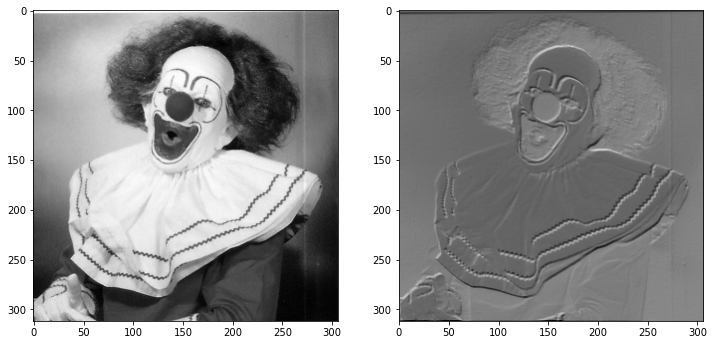

In [12]:
convolve_and_show(bobo, EMBOSS, np.sum)

### Здесь тестируем эстетичное размытие - эффект боке 

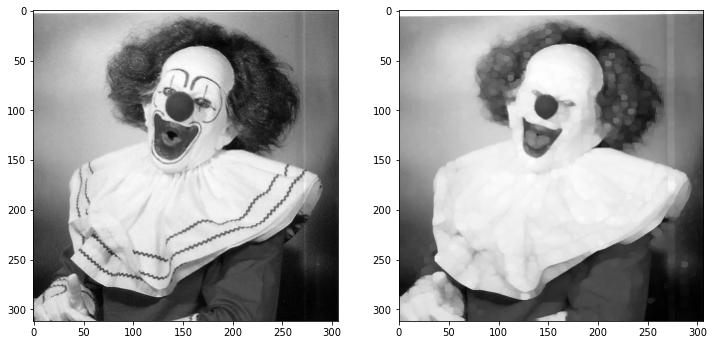

In [13]:
bokeh_effect(bobo, (6, 6))